# SVM without Kernel Trick - One Against All

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rd
import time
import pickle
from collections import defaultdict 

# Scikit-learn modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier

# Nos modules
from modules.svm import OurMultiClassOAASVMClassifier
from modules.svm import OurMultiClassOVOSVMClassifier
import modules.scoring as sc
import modules.feature_selection as fs
import modules.params_tuning as pt

## 1. Importation des données

In [2]:
data = pd.read_csv("data.csv")

In [3]:
print(data.shape)
data.head()

(1000, 32)


,filename,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,spectral_contrast,spectral_flatness,tonnetz,estimated_tempo,genre/label
0,country.00094,0.366838,0.206715,1474.849928,1745.839794,3108.264538,0.062993,-104.34503,136.39078,-20.945368,...,2.197093,-7.109390,1.849674,1.675598,-1.492039,23.567712,0.001825,0.026578,112.347147,country
1,country.00025,0.347253,0.079920,1565.431223,2016.069774,3188.930717,0.057303,-200.55273,119.67490,-3.610737,...,-11.293138,-8.870809,-8.073557,-3.161044,0.330751,19.845071,0.008667,0.018447,143.554688,country
2,country.00076,0.297332,0.128385,1321.679067,1409.586676,2590.392670,0.066525,-183.93301,159.80644,-23.158834,...,-3.583324,-9.062474,-3.159365,-4.068544,-7.052489,23.526738,0.001220,-0.013900,143.554688,country
3,country.00030,0.221390,0.079631,1240.515214,1996.754074,2412.635411,0.042844,-277.08127,128.25803,42.433240,...,1.391878,3.080010,2.513260,-1.051766,-2.753359,22.093318,0.002381,-0.009946,161.499023,country
4,country.00089,0.322114,0.104638,1321.678546,1667.211777,2583.926042,0.052503,-205.12328,140.99438,-8.959963,...,3.140506,-4.527332,2.654261,-3.122376,-10.710899,24.189410,0.001850,0.002900,143.554688,country


In [4]:
# On supprime la premiere colonne
data = data.drop(['filename'],axis=1)

# On change les noms des genres par des entiers (de 0 a 9)
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
labels = encoder.fit_transform(genre_list)
data.iloc[:, -1] = labels

Puis on normalise le jeu de données.

In [5]:
# On normalise le dataset
scaler = StandardScaler()
data_normalized = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

## 2. Apprentissage du modèle de base

On sépare tout d'abord le jeu de données pour constituer un ensemble d'apprentissage et de validation.

In [6]:
# On separe le dataset en train set et test set (80%/20%)
data_train, data_test, label_train, label_test = train_test_split(data_normalized, labels, test_size=0.2)
n_samples, n_features = data_train.shape

print("data_train {0} | label_train {1}".format(data_train.shape, label_train.shape))
print("data_test  {0} | label_test  {1}".format(data_test.shape, label_test.shape))

data_train (800, 30) | label_train (800,)
data_test  (200, 30) | label_test  (200,)


On entraîne le modèle de base, dont les paramètres par défaut sont :

        n_cuts = 40
        max_depth = 20
        max_features = 'sqrt'


Execution time to build the decision tree: 10.614869 sec


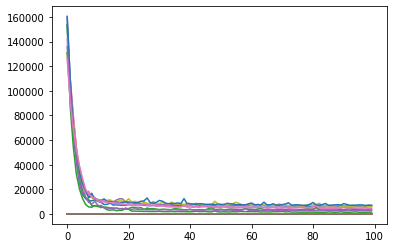

In [7]:
# Instanciation de l'arbre de decision
base_model = OurMultiClassOAASVMClassifier()
# Entrainement du modèle de base
start = time.time()
base_model.fit(data_train, label_train)
end = time.time()
print("Execution time to build the decision tree: %f sec"%(float(end) - float(start)))

# Test de validation
base_model_predictions = base_model.predict(data_test)
base_model.score_ = sc.accuracy_score(base_model_predictions, label_test) * 100

Puis on compare la performance de notre decision tree avec celle de scikit-learn.

In [8]:
# Comparaison avec sklearn


In [9]:
print("Our One-Against-All SVM score : {} %".format(base_model.score_))
#print("Sklearn score : {} %".format(sc.accuracy_score(sklearn_predictions, label_test)*100))

Our One-Against-All SVM score : 68.5 %


## 3. Wrapper-based Feature Selection
Un moyen d'améliorer notre modèle est de sélectionner les caractéristiques les plus discriminantes. 

In [10]:
print("Shape of the dataset ", data_train.shape)
print("Size of the dataset before feature selection: %.2f MB"%(data_train.nbytes/1e6))
features_name = data.drop(['genre/label'], axis=1).columns

Shape of the dataset  (800, 30)
Size of the dataset before feature selection: 0.19 MB


In [11]:
start = time.time()
features, importances = fs.findFeatureImportance(base_model, data_train, label_train)
end = time.time()
print("Execution time to find the most important feature: %f sec"%(float(end) - float(start)))

Execution time to find the most important feature: 0.915601 sec


In [12]:
feature_importances = pd.DataFrame(zip(features_name, importances), columns = ['feature','importance']).sort_values('importance', ascending=False)

feature_importances[:10]

,feature,importance
26,spectral_contrast,0.18125
0,chroma_stft,0.10375
5,zero_crossing_rate,0.10250
6,mfcc1,0.09125
7,mfcc2,0.06500
9,mfcc4,0.05625
1,rms,0.05125
19,mfcc14,0.05000
11,mfcc6,0.04250
22,mfcc17,0.03875


On selectionne les caracteristiques dont l'importance est superieure a 0.01

In [13]:
# On selectionne les caracteristiques dont l'importance est superieur a 0
indexes = feature_importances[feature_importances['importance'] > 0.01].index

# On transforme le dataset d'entrainement (fs = feature selection)
fs_data_train = fs.transform(data_train, indexes)
fs_data_test = fs.transform(data_test, indexes)

print("Shape of the dataset ", fs_data_train.shape)
print("Size of the dataset after feature selection: %.2f MB"%(fs_data_train.nbytes/1e6))

Shape of the dataset  (800, 25)
Size of the dataset after feature selection: 0.16 MB


On entraîne le modèle de base avec les caractéristiques sélectionnées.

Execution time for building the forest: 11.281519 sec


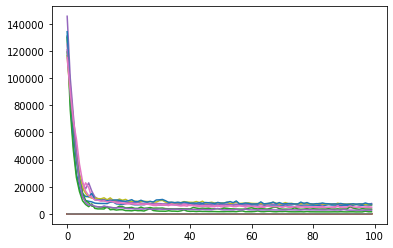

In [14]:
# Instanciation d'un arbre de décision
# Hyperparametres par defaut : n_cuts = 40, max_depth = 20
fs_base_model = OurMultiClassOAASVMClassifier()
fs_base_model.max_features = len(indexes)

# Entrainement du modèle de base avec feature selection
start = time.time()
fs_base_model.fit(fs_data_train, label_train)
end = time.time()
print("Execution time for building the forest: %f sec"%(float(end) - float(start)))

# Test de validation
fs_base_model_predictions = fs_base_model.predict(fs_data_test)
fs_base_model.score_ = sc.accuracy_score(fs_base_model_predictions, label_test) * 100

In [15]:
# Comparaison avec sklearn
#sklearn_dt.fit(fs_data_train, label_train)
#fs_sklearn_predictions = sklearn_dt.predict(fs_data_test)

On compare les scores obtenus avant et après la sélection des caractéristiques.

In [16]:
# Score
print("Before feature selection")
print("Our OAA SVM score : {} %".format(base_model.score_))
#print("Sklearn score : {} %\n".format(sc.accuracy_score(sklearn_predictions, label_test)*100))

print("After feature selection")
print("Our OAA SVM score : {} %".format(fs_base_model.score_))
#print("Sklearn score : {} %".format(sc.accuracy_score(fs_sklearn_predictions, label_test)*100))   

Before feature selection
Our OAA SVM score : 68.5 %
After feature selection
Our OAA SVM score : 67.0 %


Les scores après la sélection de caractéristisques est plus bas. Dans la suite, nous allons donc chercher le meilleur modèle à partir de l'ensemble d'apprentissage de départ `data_train` 

## 4. Réglage des hyperparamètres
Nous nous sommes fortement inspiré de la méthode décrite dans cet article [W. Koehrsen. Hyperparameter Tuning the Random Forest in Python, Janv. 2018](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)

Notre modèle a quatres paramètres que nous souhaitons optimiser  :
   - `reg_strength` -- Une constante de régularisation
   - `max_iter` -- le nombre maximum d'itérations lors de chaque decente de gradient stochastique
   - `batch_size` -- le nombre de points utilisés pour les descente de gradient stochastique
   - `learning_rate` -- le "tau" pour chaque descente de gradient, c'est à le dire le pas pour avancer vers le minimum de la fonction score

### 4.1 Random Search Cross Validation

Pour avoir une première idée de la meilleure combinaison d'hyperparamètres, nous allons effectuer une Random Search Cross Validation. Cela consiste à tester un large choix de combinaisons qui ont été formées en tirant aléatoirement des valeurs dans une grille d'hyperparamètres.

On définit la grille pour la recherche aléatoire (Random Hyperparameter Grid) :

In [17]:
# reg_strength
reg_strength = [int(x) for x in np.linspace(start = 1, stop = 301, num = 13)] 

# max_iter
max_iter = [int(x) for x in np.linspace(5, 100, num = 13)]

# batch_size
batch_size = [int(x) for x in np.linspace(1, 201, num = 13)]

# Creation de la grille
random_grid = {'reg_strength': reg_strength,
                'max_iter': max_iter,
                'batch_size': batch_size}

from pprint import pprint
print("Grille d'hyperparametres :\n")
pprint(random_grid)

Grille d'hyperparametres :

{'batch_size': [1, 17, 34, 51, 67, 84, 101, 117, 134, 151, 167, 184, 201],
 'max_iter': [5, 12, 20, 28, 36, 44, 52, 60, 68, 76, 84, 92, 100],
 'reg_strength': [1, 26, 51, 76, 101, 126, 151, 176, 201, 226, 251, 276, 301]}


Au lieu de tester 5 x 4 x 5 = 100 combinaisons d'hyperparamètres, nous allons seulement en sélectionner quelques unes aléatoirement. On procède à la recherche randomisée sur 50 combinaisons, en utilisant une 5-fold CV.

Execution time for random search training: 994.851684 sec


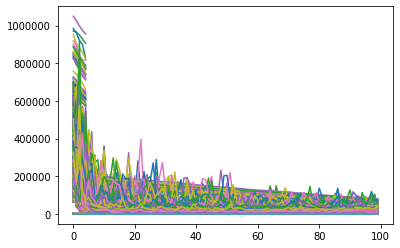

In [18]:
# 16 MIN
# Definition de la recherche randomisee
random_dtc = pt.RandomizedSearchCV(estimator = OurMultiClassOAASVMClassifier, 
                                  param_distributions = random_grid, 
                                  n_iter = 50, 
                                  cv = 5)

# Entrainement du modele
start = time.time()
random_dtc.fit(data_train, label_train)
end = time.time()
print("Execution time for random search training: %f sec"%(float(end) - float(start)))

On affiche les meilleurs hyperparamètres résultant de la recherche randomisée :

In [19]:
print("The best hyperparameters from Random Search are:\n", random_dtc.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:\n %.2f"%(random_dtc.best_score_ * 100))

The best hyperparameters from Random Search are:
 {'reg_strength': 226, 'max_iter': 100, 'batch_size': 201, 'learning_rate': 0.0001}

The mean accuracy of a model with these hyperparameters is:
 65.12


### 4.2 Grid Search Cross Validation
On peut maintenant effectuer une recherche plus exhaustive centrée sur ces valeurs.

In [22]:
# Definition de la grille d'hyperparamètres basée sur les résultats de la recherche randomisée
reg_strength = [220,226,230]
max_iter = [90,100,110]
batch_size = [185, 201]

param_grid = {'reg_strength': reg_strength,
                'max_iter': max_iter,
                'batch_size': batch_size}

Execution time for random search training: 792.149439 sec


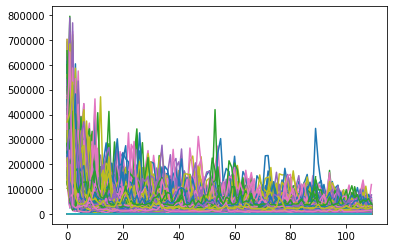

In [23]:
# 4-5 MIN
# Instanciation du grid search model
grid_search_dtc = pt.GridSearchCV(estimator = OurMultiClassOAASVMClassifier, 
                                  param_distributions = param_grid,
                                  cv = 5)

# Entrainement du modele
start = time.time()
grid_search_dtc.fit(data_train, label_train)
end = time.time()
print("Execution time for random search training: %f sec"%(float(end) - float(start)))

La meilleur combinaison d'hyperparamètres est :

In [24]:
print("The best hyperparameters from Grid Search are:\n", grid_search_dtc.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:\n %.2f"%(grid_search_dtc.best_score_ * 100))

The best hyperparameters from Grid Search are:
 {'reg_strength': 220, 'max_iter': 110, 'batch_size': 201, 'learning_rate': 0.0001}

The mean accuracy of a model with these hyperparameters is:
 65.12


On sauvegarde le meilleur modèle dans `best_dtc` :

In [25]:
best_dtc = grid_search_dtc.best_estimator_

## 5. Apprentissage du meilleur modèle et performance

Maintenant que nous avons le meilleur modèle, entraînons-le et observons ses performances.

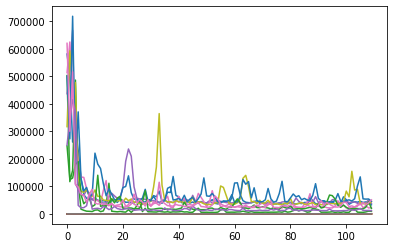

In [26]:
# Entrainement du meilleur modele
best_dtc.fit(data_train, label_train)

# Test de validation
best_dtc_predictions = best_dtc.predict(data_test)
best_dtc.score_ = sc.accuracy_score(best_dtc_predictions, label_test) * 100

### Matrice de confusion

In [27]:
d = {
    'genre': genre_list,
    'genre_code': labels
}
df_genre = pd.DataFrame(d).drop_duplicates().sort_values('genre_code')
df_genre

,genre,genre_code
800,blues,0
900,classical,1
0,country,2
500,disco,3
400,hiphop,4
700,jazz,5
100,metal,6
600,pop,7
200,reggae,8
300,rock,9


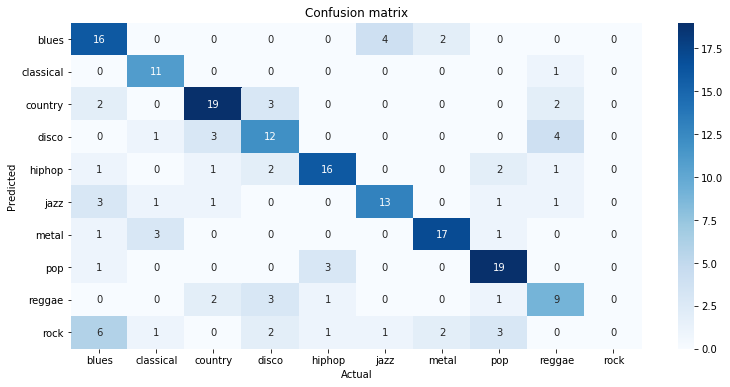

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(label_test, best_dtc_predictions)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix,
            annot=True,
            xticklabels=df_genre['genre'].values,
            yticklabels=df_genre['genre'].values,
            cmap="Blues")
            
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

Voyons si le réglage des hyperparamètres a permis d'obtenir un meilleur modèle.

In [29]:
print("Base model score: {} %".format(base_model.score_))
print("Best model score: {} %".format(best_dtc.score_ ))

Base model score: 68.5 %
Best model score: 66.0 %


Sauvegardons le score du modèle pour pouvoir le comparer aux autres modèles.

In [30]:
d = {
    'Model': 'OAA-SVM',
    'Test Set Accuracy': best_dtc.score_
}

df_models_dtc = pd.DataFrame(d, index=[0])

In [1]:
with open('models/best_oaasvm.pickle', 'wb') as output:
    pickle.dump(best_dtc, output)

with open('models/df_models_oaasvm.pickle', 'wb') as output:
    pickle.dump(df_models_dtc, output)

NameError: name 'pickle' is not defined